In [1]:
#-----------------------------------------------------------------------------
# Importa bibliotecas e define variáveis
#-----------------------------------------------------------------------------

import numpy as np
import pandas as pd
import scipy as sp
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import minmax_scale
from sklearn.ensemble import RandomForestClassifier
from scipy.optimize import Bounds
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Lasso, LassoCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import Ridge, RidgeCV, RidgeClassifierCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn import svm
import seaborn as sns

janela_reb = 126
janela_retornos = 252
janela_indic = 252
custo = 0.0025
rnd_state = 10
thresh = 0.55
str_dir = 'C:/Users/nelly/Desktop/Mestrado Insper/DISSERTAÇÃO/Dissertação/1. Modelo/'

In [2]:
#-----------------------------------------------------------------------------
# Define funções - Otimização de Portfolio Markowitz
#-----------------------------------------------------------------------------

def get_port(mu,cov,df_y_hat_local_T,w_barra,wu,gamma):
    
    N_t = df_y_hat_local_T.shape[1]
    n_pc = df_y_hat_local_T.shape[0]
    
    theta0 = np.zeros(n_pc)
    
    x_t = np.array(df_y_hat_local_T)
    
    alfa1 = 10e9
    alfa2 = 10e9
    alfa3 = 10e9
    
    fun = lambda theta: -((1 + (w_barra + (1/N_t)*(theta).dot(x_t)).dot(np.array(mu)) - \
                            np.abs((w_barra + (1/N_t)*(theta).dot(x_t))-wu).sum()*custo)**(1-gamma)-1)/(1-gamma) + \
                            alfa1*((w_barra + (1/N_t)*theta.dot(x_t)).sum() - 1)**2 + \
                            alfa2*np.max((w_barra + (1/N_t)*theta.dot(x_t))<-0.2)**2 + \
                            alfa3*np.max((w_barra + (1/N_t)*theta.dot(x_t))>0.2)**2

    res = opt.minimize(fun, theta0, method='Nelder-Mead',
                       options={'maxiter':10000, 'ftol': 1e-07, 'disp':True})
    
    theta = pd.Series(data=res.x)
    
    w = w_barra + (1/N_t)*(theta).dot(x_t)
    
    r_opt = (w_barra + (1/N_t)*(theta).dot(x_t)).dot(np.array(mu)) - np.abs(((w_barra + (1/N_t)*(theta).dot(x_t))-wu)).sum()*custo
    
    vol_opt = (w_barra + (1/N_t)*(theta).dot(x_t)).dot(cov).dot((w_barra + (1/N_t)*(theta).dot(x_t)))
    
    return w, res.fun, r_opt, vol_opt, theta

In [3]:
str_indic_full = ['EBITDA_MARGIN','EBIT_MARGIN',
                  'RETURN_COM_EQY','RETURN_ON_ASSET','RETURN_ON_CAP','RETURN_ON_INV_CAPITAL',
                  'OPER_MARGIN','ASSET_TURNOVER','CUR_RATIO','QUICK_RATIO',
                  'INT_COVERAGE_RATIO','DEGREE_FINANCIAL_LEVERAGE',
                  'BS_LEV_RATIO_TO_TANG_CAP','BEST_DIV_YLD','DVD_PAYOUT_RATIO',
                  'EV_TO_T12M_EBITDA','EV_TO_T12M_EBIT','PX_TO_BOOK_RATIO','PE_RATIO',
                  'PX_TO_SALES_RATIO','CURRENT_EV_TO_12M_SALES','BEST_PEG_RATIO',
                  'NET_INCOME_TO_COMMON_MARGIN','CUR_MKT_CAP',
                  'PX_TO_CASH_FLOW','PX_TO_FREE_CASH_FLOW','EQY_DVD_YLD_12M_NET',
                  'CASH_CONVERSION_CYCLE','OPERATING_ROIC','PRETAX_ROCE']
str_tickers_full = ['VALE3 BS Equity','B3SA3 BS Equity','ITUB4 BS Equity','PETR4 BS Equity',
               'BBDC4 BS Equity','PETR3 BS Equity','ABEV3 BS Equity','WEGE3 BS Equity',
               'BBAS3 BS Equity','ITSA4 BS Equity','JBSS3 BS Equity','NTCO3 BS Equity',
               'LREN3 BS Equity','RENT3 BS Equity','LAME4 BS Equity','BBDC3 BS Equity',
               'EQTL3 BS Equity','RADL3 BS Equity','VIVT4 BS Equity','UGPA3 BS Equity',
               'SBSP3 BS Equity','GGBR4 BS Equity','BRFS3 BS Equity','CCRO3 BS Equity',
               'HYPE3 BS Equity','SULA11 BS Equity','COGN3 BS Equity','CSAN3 BS Equity',
               'ENGI11 BS Equity','TOTS3 BS Equity','EGIE3 BS Equity','CMIG4 BS Equity',
               'YDUQ3 BS Equity','CSNA3 BS Equity','BRML3 BS Equity','CYRE3 BS Equity',
               'TAEE11 BS Equity','BRKM5 BS Equity','MULT3 BS Equity','EMBR3 BS Equity',
               'GOAU4 BS Equity','MRVE3 BS Equity','ENBR3 BS Equity','CPFE3 BS Equity',
               'USIM5 BS Equity','HGTX3 BS Equity']

df_full = pd.read_csv(filepath_or_buffer = str_dir + 'Indicadores Nelly' + '.csv', sep=';')
df_full.index = df_full['Date']
df_full = df_full.drop(columns=['Date'])
df_full['indice'] = np.zeros(len(df_full.index))

In [4]:
for x in range(0,len(df_full.index)):
    df_full.iloc[x,len(df_full.columns)-1] = datetime.datetime(df_full.iloc[x,2],df_full.iloc[x,1], df_full.iloc[x,0])

df_full = df_full.drop(columns=['Day', 'Month', 'Year'])
df_full.index = df_full['indice']
df_full = df_full.drop(columns=['indice'])

df_full = df_full.iloc[(252*10):,]

# Importa base de retornos das ações do Ibovespa 
str_Retornos = 'Retornos Nelly'
    
df_Retornos = pd.read_csv(filepath_or_buffer = str_dir + str_Retornos + '.csv', sep=';')
df_Retornos.index = df_Retornos['Data']
df_Retornos = df_Retornos.drop(columns=['Data'])
df_Retornos = df_Retornos.dropna()
    
df_Retornos['indice']=np.zeros(len(df_Retornos.index))
    
for x in range(0,len(df_Retornos.index)):
    df_Retornos.iloc[x,len(df_Retornos.columns)-1] = datetime.datetime(df_Retornos.iloc[x,2],df_Retornos.iloc[x,1], df_Retornos.iloc[x,0])
    
df_Retornos = df_Retornos.drop(columns=['Day', 'Month', 'Year'])
df_Retornos.index = df_Retornos['indice']
df_Retornos = df_Retornos.drop(columns=['indice'])

# Importa base de pesos das ações do portfolio     
str_w0 = 'Market_Cap'
    
df_w0 = pd.read_csv(filepath_or_buffer = str_dir + str_w0 + '.csv', sep=';')
df_w0.index = df_w0['Data']
df_w0 = df_w0.drop(columns=['Data'])
df_w0 = df_w0.dropna()
    
df_w0['indice']=np.zeros(len(df_w0.index))
    
for x in range(0,len(df_w0.index)):
    df_w0.iloc[x,len(df_w0.columns)-1] = datetime.datetime(df_w0.iloc[x,2],df_w0.iloc[x,1], df_w0.iloc[x,0])
    
df_w0 = df_w0.drop(columns=['Day', 'Month', 'Year'])
df_w0.index = df_w0['indice']
df_w0 = df_w0.drop(columns=['indice'])

In [5]:
# Ajusta série de datas
data_retornos = pd.DataFrame(df_Retornos.index)
data_indic = pd.DataFrame(df_full.index)
data_series = data_retornos.merge(data_indic, left_on = 'indice', right_on = 'indice')

df_Retornos = df_Retornos[df_Retornos.index.isin(data_series['indice'])]
df_full = df_full[df_full.index.isin(data_series['indice'])]
df_w0 = df_w0[df_w0.index.isin(data_series['indice'])]

num_indic = len(str_indic_full)
v_pos_indics = []
j = 0
while j != len(df_full.columns):
    if np.isnan(df_full.iloc[0,j]) or df_full.iloc[0,j] == 0 or df_full.iloc[0,j] == 'NaN':
        pos_indic = j%num_indic
        indic_list = False
        for i in range(0,len(v_pos_indics)):
            if v_pos_indics[i] == pos_indic:
                indic_list = True
        if indic_list == False:
            v_pos_indics.append(pos_indic)
    j = j + 1
str_indic_full_aux = []
for i in range(0,len(str_indic_full)):
    if i not in v_pos_indics:
        str_indic_full_aux.append(str_indic_full[i])
str_indic_full = str_indic_full_aux
str_drop_cols = []
for i in range(0, len(v_pos_indics)):
    col = v_pos_indics[i]
    while col < len(df_full.columns):
        str_drop_cols.append(df_full.columns[col])
        col = col + num_indic
df_full = df_full.drop(labels = str_drop_cols, axis = 1)


In [6]:
df_GROSS_MARGIN = pd.DataFrame()
df_EBITDA_MARGIN = pd.DataFrame()
df_PROF_MARGIN = pd.DataFrame()
df_EBIT_MARGIN = pd.DataFrame()
df_RETURN_COM_EQY = pd.DataFrame()
df_RETURN_ON_ASSET = pd.DataFrame()
df_RETURN_ON_CAP = pd.DataFrame()
df_RETURN_ON_INV_CAPITAL = pd.DataFrame()
df_OPER_MARGIN = pd.DataFrame()
df_ASSET_TURNOVER = pd.DataFrame()
df_CUR_RATIO = pd.DataFrame()
df_QUICK_RATIO = pd.DataFrame()
df_INT_COVERAGE_RATIO = pd.DataFrame()
df_DEGREE_FINANCIAL_LEVERAGE = pd.DataFrame()
df_BS_LEV_RATIO_TO_TANG_CAP = pd.DataFrame()
df_BEST_DIV_YLD = pd.DataFrame()
df_DVD_PAYOUT_RATIO = pd.DataFrame()
df_EV_TO_T12M_EBITDA = pd.DataFrame()
df_EV_TO_T12M_EBIT = pd.DataFrame()
df_PX_TO_BOOK_RATIO = pd.DataFrame()
df_PE_RATIO = pd.DataFrame()
df_PX_TO_SALES_RATIO = pd.DataFrame()
df_CURRENT_EV_TO_12M_SALES = pd.DataFrame()
df_BEST_PEG_RATIO = pd.DataFrame()
df_PROF_MARGIN = pd.DataFrame()
df_NET_INCOME_TO_COMMON_MARGIN = pd.DataFrame()
df_CUR_MKT_CAP = pd.DataFrame()
df_PX_TO_CASH_FLOW = pd.DataFrame()
df_PX_TO_FREE_CASH_FLOW = pd.DataFrame()
df_EQY_DVD_YLD_12M_NET = pd.DataFrame()
df_CASH_CONVERSION_CYCLE = pd.DataFrame()
df_OPERATING_ROIC = pd.DataFrame()
df_PRETAX_ROCE = pd.DataFrame()

In [7]:
col = 0
j = 0
num_indic = len(str_indic_full)
for indic in str_indic_full:
    while col < df_full.shape[1]:
        globals()['df_' + indic] = pd.concat([globals()['df_' + indic], 
                                              df_full.iloc[:,col]], axis = 1)
        col = col + num_indic
    globals()['df_' + indic].columns = str_tickers_full
    j = j + 1
    col = j

# Definição dos tickers a serem consultados nas bases para otimização
str_tickers = str_tickers_full

# Definição dos indicadores que serão utilizados para ajustar os modelos
str_indic = str_indic_full

t = janela_indic
T = len(df_RETURN_COM_EQY)

wu = np.zeros(len(str_tickers))
df_w = pd.DataFrame()
df_r = pd.DataFrame()
df_Vol = pd.DataFrame()
df_Utility = pd.DataFrame()
df_theta = pd.DataFrame()

In [8]:
while t < T:
        
    df_indic_stocks = pd.DataFrame()
    df_indic_stocks_ini = pd.DataFrame()
    df_indic_stocks_ini2 = pd.DataFrame()
    df_indic_stocks_fim = pd.DataFrame()   
    
    for ticker in str_tickers:
        
        df_indic = pd.DataFrame()
        
        for indic in str_indic_full:
            df_indic = pd.concat([df_indic, 
                                  globals()['df_' + indic][ticker].iloc[(t-janela_indic):t]], axis = 1)

        df_indic = pd.DataFrame(scale(minmax_scale(df_indic)))
    
        p = len(df_indic)
         
        df_indic_stocks_fim = pd.concat([df_indic_stocks_fim, df_indic.iloc[p-1,:]], axis = 1)
        df_indic_stocks_fim_T = df_indic_stocks_fim.T
    
    df_indic_stocks_fim.columns = [str_tickers]
    df_indic_stocks_fim.index = str_indic
    
    # Otimização
    
    mu = np.mean(df_Retornos.iloc[(t-janela_retornos):t])*252
    cov = df_Retornos.iloc[(t-janela_retornos):t].cov()*252
    
    df_signals = df_indic_stocks_fim
    
    w_barra = np.array(df_w0.iloc[t,:])
    
    w_opt, utility_opt, r_opt, vol_opt, theta_opt = get_port(mu, cov, 
                                                             df_signals, 
                                                             w_barra,
                                                             wu,
                                                             gamma=5)
    
    df_w = pd.concat([df_w,pd.DataFrame(w_opt)], axis = 1)
    df_Utility = pd.concat([df_Utility, pd.DataFrame(data=[utility_opt])], axis = 1)
    df_r = pd.concat([df_r, pd.DataFrame(data=[r_opt])], axis = 1)
    df_Vol = pd.concat([df_Vol, pd.DataFrame(data=[vol_opt])], axis = 1)
    df_theta = pd.concat([df_theta, pd.DataFrame(data=[theta_opt])], axis = 1)
    wu = w_opt 
    
    t = t + janela_reb 

Optimization terminated successfully.
         Current function value: -0.173567
         Iterations: 784
         Function evaluations: 1234
Optimization terminated successfully.
         Current function value: 10000000000.512806
         Iterations: 198
         Function evaluations: 390
Optimization terminated successfully.
         Current function value: -0.131810
         Iterations: 249
         Function evaluations: 475
Optimization terminated successfully.
         Current function value: -0.237354
         Iterations: 816
         Function evaluations: 1286
Optimization terminated successfully.
         Current function value: -0.070986
         Iterations: 232
         Function evaluations: 444
Optimization terminated successfully.
         Current function value: -0.115296
         Iterations: 238
         Function evaluations: 460
Optimization terminated successfully.
         Current function value: -0.100222
         Iterations: 249
         Function evaluations: 478
Op

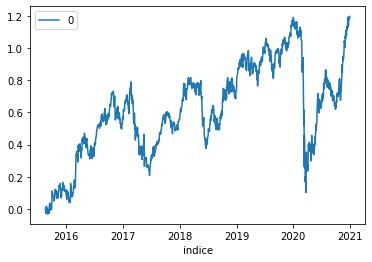

In [9]:
#----------------------------------------------------------------------------------------------
#  Guarda retorno dos portfolios otimizados
#----------------------------------------------------------------------------------------------   
    
df_ret_acao_per = pd.DataFrame()
df_ret_opt = pd.DataFrame()
itera = 0
acao = 0
t = janela_retornos
while t < T:
        
    retornos_aux = np.array(df_Retornos.iloc[(t+1):(t+janela_reb+1)])
    
    if itera > 0:
        w_novo = np.array(df_w.iloc[:,itera])
        df_ret_opt.iloc[len(df_ret_opt)-1,0] = df_ret_opt.iloc[len(df_ret_opt)-1,0] - np.abs(w_novo-w_aux).sum()*custo
    
    w_aux = np.array(df_w.iloc[:,itera])
        
    for i in range(0,retornos_aux.shape[0]):
            
        df_ret_opt = pd.concat([df_ret_opt, 
                                   pd.DataFrame(data=[(w_aux*retornos_aux[i,:]).sum()])], 
                                   axis = 0)
            
    itera = itera + 1    
    t = t + janela_reb

df_ret_opt.index = df_Retornos.index[(janela_retornos+1):len(df_Retornos.index)]

sns.lineplot(data = np.exp(df_ret_opt.cumsum())-1)

df_ret_opt.to_csv(str_dir + 'BRANDT_INDICADORES_DIRETO.csv')
